In [1]:
!pip install fastai2
!pip install fastai2>=0.0.11 graphviz kornia ipywidgets matplotlib nbdev>=0.2.12 pandas scikit_learn azure-cognitiveservices-search-imagesearch sentencepiece

     |████████████████████████████████| 190 kB 3.4 MB/s 
ERROR: kornia 0.3.0 has requirement torch==1.5.0, but you'll have torch 1.4.0 which is incompatible.


In [2]:
from fastai2.vision.all import *
from fastai2.medical.imaging import *

In [3]:
trn_path = Path('../input/rsna-hemorrhage-jpg/train_jpg/train_jpg/')
csv_path = Path('../input/all-csvs/')

In [4]:
# fn = get_image_files(trn_path)
# len(fn)

In [5]:
labels = pd.read_csv(csv_path/'new_labels.csv')
labels.head()

,Unnamed: 0,ID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,multi
0,0,ID_0002081b6.jpg,0,intraparenchymal,0,0,0,intraparenchymal
1,1,ID_0002a38ad.jpg,0,0,0,subarachnoid,subdural,subarachnoid;subdural
2,2,ID_000346ce2.jpg,0,0,0,0,subdural,subdural
3,3,ID_00042829c.jpg,0,0,intraventricular,0,0,intraventricular
4,4,ID_0004a5701.jpg,0,0,0,0,subdural,subdural


In [6]:
labels.columns

Index(['Unnamed: 0', 'ID', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural', 'multi'],
      dtype='object')

In [7]:
labels = labels.drop(['Unnamed: 0', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural'], axis = 1)
labels.head()

,ID,multi
0,ID_0002081b6.jpg,intraparenchymal
1,ID_0002a38ad.jpg,subarachnoid;subdural
2,ID_000346ce2.jpg,subdural
3,ID_00042829c.jpg,intraventricular
4,ID_0004a5701.jpg,subdural


In [8]:
tfms = aug_transforms(p_lighting=0.)
opt_func = partial(Adam, wd=0.01, eps=1e-3)

In [9]:
dls = ImageDataLoaders.from_df(labels, trn_path, label_delim=';', batch_tfms=tfms, seed = 42)

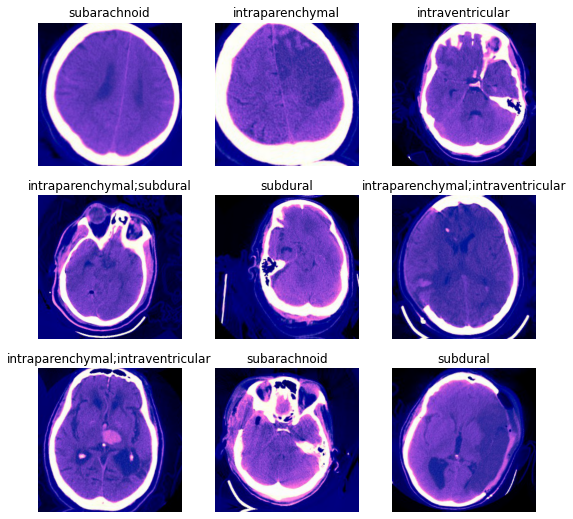

In [10]:
dls.show_batch()

In [11]:
len(dls.train_ds), len(dls.valid_ds), dls.bs

(77633, 19408, 64)

In [12]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5), opt_func=opt_func, model_dir = '/kaggle')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.033113110810518265)

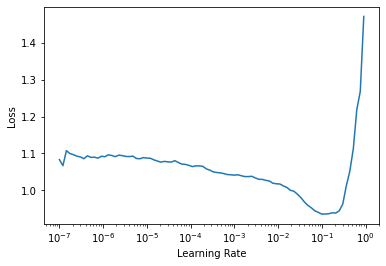

In [13]:
learn.lr_find()

In [14]:
learn.fine_tune(5, base_lr= 1e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.366925,0.353408,0.849350,08:40


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.292253,0.279617,0.883759,10:03
1,0.258705,0.258741,0.893498,10:02
2,0.233395,0.227548,0.906297,10:13
3,0.208624,0.213008,0.912037,10:01


In [15]:
learn.save("/kaggle/working/wd-stage1")

SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=4.786300905834651e-06)

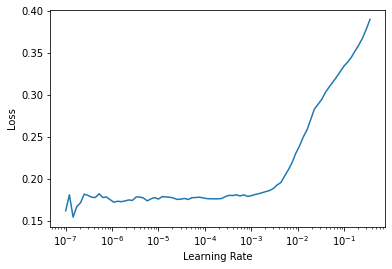

In [16]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(5, lr_max=slice(1e-6,5e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.180591,0.206322,0.916261,10:01
1,0.182022,0.205581,0.916076,10:02
2,0.180374,0.204874,0.916498,10:00
3,0.176790,0.204804,0.916509,10:14
4,0.180125,0.204271,0.916890,10:01


In [18]:
learn.save("/kaggle/working/wd-stage2")

SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=1.2022644114040304e-05)

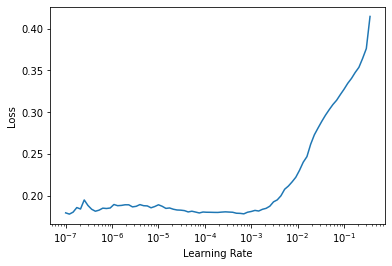

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(5, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.175827,0.204583,0.916457,10:00
1,0.175061,0.204115,0.916973,10:01
2,0.170688,0.204103,0.917137,10:01
3,0.171923,0.203862,0.917364,10:01


In [21]:
learn.save("/kaggle/working/wd-stage3")

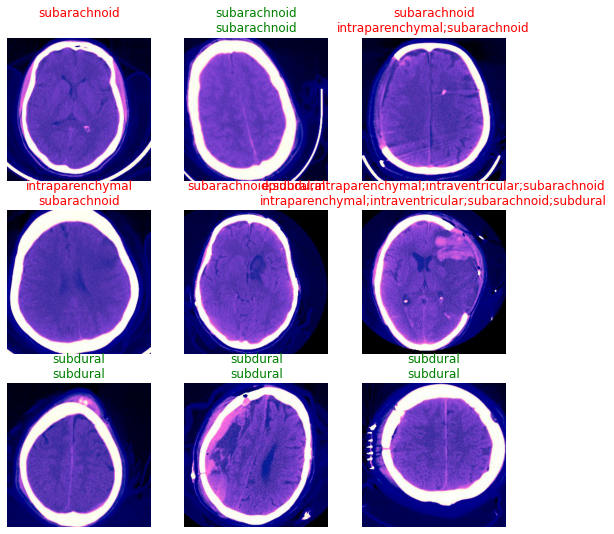

In [22]:
learn.show_results()